In [1]:
#GPU count and name
!nvidia-smi -L

GPU 0: Tesla K40m (UUID: GPU-f2f1ed91-fb8c-89c1-c31d-49184577a1a0)
GPU 1: Tesla K40m (UUID: GPU-968502a1-c33f-5ed3-2f41-0b81c0c88c82)
GPU 2: Tesla K40m (UUID: GPU-d38b3db2-339f-018e-d167-0dd1d9811921)
GPU 3: Tesla K40m (UUID: GPU-016818ce-7be5-5640-718d-57fc2db69cac)


In [2]:
# watch --interval 1 nvidia-smi
!nvidia-smi

Tue Jun 18 16:30:24 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.40.04    Driver Version: 418.40.04    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K40m          On   | 00000000:03:00.0 Off |                    0 |
| N/A   45C    P0    62W / 235W |      0MiB / 11441MiB |      0%   E. Process |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K40m          On   | 00000000:04:00.0 Off |                    0 |
| N/A   30C    P8    21W / 235W |      0MiB / 11441MiB |      0%   E. Process |
+-------------------------------+----------------------+----------------------+
|   2  T

In [3]:
%matplotlib inline
%load_ext lab_black

import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
from numba import cuda

## Simulate Data

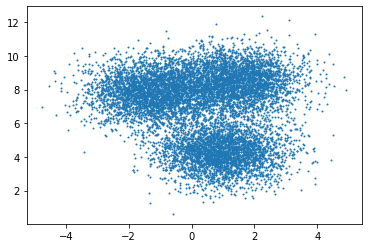

In [4]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

n_features = 6
blob, _ = make_blobs(n_samples=10000, n_features=n_features, random_state=0)
eval_points = np.linspace(-10, 10)
grid = np.meshgrid(eval_points, eval_points)
x_grid, y_grid = grid
grid = np.stack([g.flat for g in grid], axis=1)
b = np.ones((n_features,))


blob = blob.astype(np.float32)
b = b.astype(np.float32)

plt.scatter(blob[:, 0], blob[:, 1], s=1)

In [5]:
eval_points = np.concatenate((grid, blob[0, 2:] * np.ones((grid.shape[0], 1))), axis=1)
eval_points = eval_points.astype(np.float32)

## Cupy KDE

In [6]:
import math


def gaussian(x):
    return cp.exp(-0.5 * x ** 2) / cp.sqrt(2 * cp.pi)


@cp.fuse()
def cupy_kde(eval_points, samples, bandwidths):
    eval_points = cp.asarray(eval_points)
    samples = cp.asarray(samples)
    bandwidths = cp.asarray(bandwidths)

    return cp.asnumpy(
        cp.mean(
            cp.prod(
                gaussian(
                    (
                        (
                            cp.expand_dims(eval_points, axis=0)
                            - cp.expand_dims(samples, axis=1)
                        )
                        / bandwidths
                    )
                ),
                axis=-1,
            ),
            axis=0,
        )
        / cp.prod(bandwidths)
    )

In [7]:
result = cupy_kde(eval_points, blob, b)

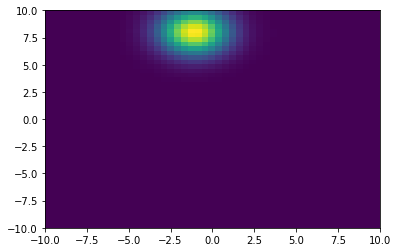

In [8]:
plt.pcolormesh(x_grid, y_grid, result.reshape((50, 50)))

In [9]:
%timeit cp.cuda.stream.get_current_stream().synchronize(); cupy_kde(eval_points, blob, b); cp.cuda.stream.get_current_stream().synchronize();

131 ms ± 45.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
from sklearn.neighbors import KernelDensity

np.allclose(
    np.exp(KernelDensity(bandwidth=b[0]).fit(blob).score_samples(eval_points)),
    cupy_kde(eval_points, blob, b),
)

True

## NUMBA CPU

In [11]:
import numba
import math

SQRT_2PI = np.float32(math.sqrt(2.0 * math.pi))


@numba.vectorize(
    ["float32(float32, float32, float32)"], nopython=True, target="cpu", fastmath=True
)
def gaussian_pdf(x, mean, sigma):
    """Compute the value of a Gaussian probability density function at x with given mean and sigma."""
    return math.exp(-0.5 * ((x - mean) / sigma) ** 2) / (sigma * SQRT_2PI)


@numba.njit(
    "float32[:](float32[:, :], float32[:, :], float32[:])",
    parallel=True,
    fastmath=True,
    nogil=True,
)
def numba_kde_multithread2(eval_points, samples, bandwidths):
    n_eval_points = len(eval_points)
    result = np.zeros((n_eval_points,), dtype=np.float32)
    n_samples = len(samples)
    denom = n_samples * np.prod(bandwidths)

    for i in numba.prange(n_eval_points):
        for j in range(n_samples):
            result[i] += np.prod(gaussian_pdf(eval_points[i], samples[j], bandwidths))
        result[i] /= denom

    return result


result = numba_kde_multithread2(eval_points, blob, b)

In [12]:
%timeit numba_kde_multithread2(eval_points, blob, b)

309 ms ± 10.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## NUMBA CUDA GPU
+ One eval point only

In [13]:
from numba import cuda
import math

SQRT_2PI = np.float32(math.sqrt(2.0 * math.pi))


@cuda.jit(device=True, inline=True)
def gaussian_pdf(x, mean, sigma):
    """Compute the value of a Gaussian probability density function at x with given mean and sigma."""
    return math.exp(-0.5 * ((x - mean) / sigma) ** 2) / (sigma * SQRT_2PI)


@cuda.jit
def numba_kde_cuda(eval_points, samples, bandwidths, out):
    thread_id = cuda.grid(1)
    stride = cuda.gridsize(1)
    n_samples = samples.shape[0]

    for sample_ind in range(thread_id, n_samples, stride):
        diff = 1.0
        for bandwidth_ind in range(bandwidths.shape[0]):
            diff *= (
                gaussian_pdf(
                    eval_points[0, bandwidth_ind],
                    samples[sample_ind, bandwidth_ind],
                    bandwidths[bandwidth_ind],
                )
                / bandwidths[bandwidth_ind]
            )
        diff /= n_samples
        cuda.atomic.add(out, 0, diff)

In [14]:
out = np.zeros((1,), dtype=np.float32)

threads_per_block = 64
n_eval_points = 1
n_train, n_test = blob.shape[0], n_eval_points
blocks_per_grid = ((n_train * n_test) + (threads_per_block - 1)) // threads_per_block


numba_kde_cuda[blocks_per_grid, threads_per_block](eval_points[[0]], blob, b, out)

print(out)

[0.]


In [15]:
numba_kde_multithread2(eval_points, blob, b)[0]

0.0

## NUMBA CUDA GPU2
+ All eval points (one spike, all position bins)
+ Using atomic add

In [16]:
@cuda.jit
def numba_kde_cuda2(eval_points, samples, bandwidths, out):
    thread_id1, thread_id2 = cuda.grid(2)
    stride1, stride2 = cuda.gridsize(2)
    (n_eval, n_bandwidths), n_samples = eval_points.shape, samples.shape[0]

    for eval_ind in range(thread_id1, n_eval, stride1):
        for sample_ind in range(thread_id2, n_samples, stride2):
            diff = 1.0
            for bandwidth_ind in range(n_bandwidths):
                diff *= (
                    gaussian_pdf(
                        eval_points[eval_ind, bandwidth_ind],
                        samples[sample_ind, bandwidth_ind],
                        bandwidths[bandwidth_ind],
                    )
                    / bandwidths[bandwidth_ind]
                )
            diff /= n_samples
            cuda.atomic.add(out, eval_ind, diff)

In [17]:
n_eval_points = eval_points.shape[0]
out = np.zeros((n_eval_points,), dtype=np.float32)
n_train, n_test = blob.shape[0], n_eval_points

threads_per_block = 8, 8
blocks_per_grid_x = math.ceil(n_test / threads_per_block[0])
blocks_per_grid_y = math.ceil(n_train / threads_per_block[1])
blocks_per_grid = blocks_per_grid_x, blocks_per_grid_y

numba_kde_cuda2[blocks_per_grid, threads_per_block](eval_points, blob, b, out)

In [18]:
np.allclose(numba_kde_multithread2(eval_points, blob, b), out)

True

In [19]:
from sklearn.neighbors import KernelDensity

np.allclose(
    np.exp(KernelDensity(bandwidth=b[0]).fit(blob).score_samples(eval_points)), out
)

True

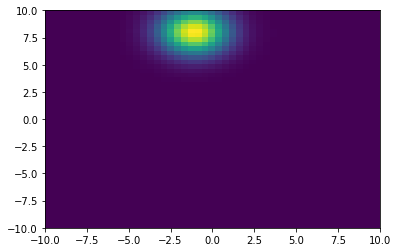

In [20]:
result = np.exp(KernelDensity(bandwidth=b[0]).fit(blob).score_samples(eval_points))

plt.pcolormesh(x_grid, y_grid, result.reshape((50, 50)))

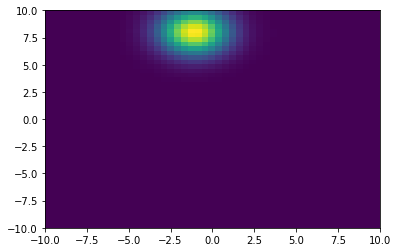

In [21]:
plt.pcolormesh(x_grid, y_grid, out.reshape((50, 50)))

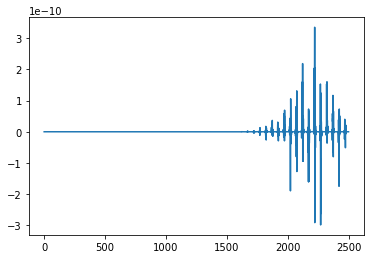

In [22]:
plt.plot(out - numba_kde_multithread2(eval_points, blob, b))

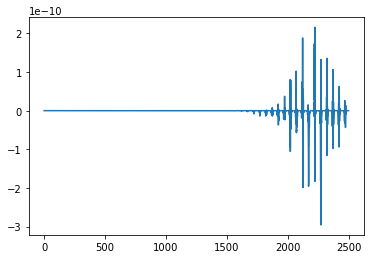

In [23]:
plt.plot(
    out - np.exp(KernelDensity(bandwidth=b[0]).fit(blob).score_samples(eval_points))
)

In [24]:
%timeit cuda.synchronize(); numba_kde_cuda2[blocks_per_grid, threads_per_block](eval_points, blob, b, out); cuda.synchronize()

27.6 ms ± 774 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [25]:
%timeit KernelDensity(bandwidth=b[0]).fit(blob).score_samples(eval_points)

1.14 s ± 148 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
%timeit numba_kde_multithread2(eval_points, blob, b)

312 ms ± 18.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
%timeit cp.cuda.stream.get_current_stream().synchronize(); cupy_kde(eval_points, blob, b); cp.cuda.stream.get_current_stream().synchronize();

131 ms ± 17.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## NUMBA CUDA GPU3
+ Loop over all spikes and covariate bins
+ Using atomic add

In [28]:
@cuda.jit
def numba_kde_cuda3(covariate_bins, marks, samples, bandwidths, out):
    thread_id1, thread_id2, thread_id3 = cuda.grid(3)
    stride1, stride2, stride3 = cuda.gridsize(3)

    n_bins, n_cov = covariate_bins.shape
    n_test, n_features = marks.shape
    n_samples = samples.shape[0]

    for test_ind in range(thread_id1, n_test, stride1):
        for bin_ind in range(thread_id2, n_bins, stride2):
            for sample_ind in range(thread_id3, n_samples, stride3):
                diff = 1.0

                for cov_ind in range(n_cov):
                    diff *= (
                        gaussian_pdf(
                            covariate_bins[bin_ind, cov_ind],
                            samples[sample_ind, cov_ind],
                            bandwidths[cov_ind],
                        )
                        / bandwidths[cov_ind]
                    )

                for feature_ind in range(n_features):
                    diff *= (
                        gaussian_pdf(
                            marks[test_ind, feature_ind],
                            samples[sample_ind, n_cov + feature_ind],
                            bandwidths[n_cov + feature_ind],
                        )
                        / bandwidths[n_cov + feature_ind]
                    )

                diff /= n_samples

                cuda.atomic.add(out, (test_ind, bin_ind), diff)

In [29]:
# n_samples, n_test = blob.shape[0], blob.shape[0]
# n_bins, n_cov = grid.shape
# n_marks = 4
# out = np.zeros((n_test, n_bins))


# threads_per_block = 4, 8, 4
# blocks_per_grid_x = math.ceil(n_test / threads_per_block[0])
# blocks_per_grid_y = math.ceil(n_bins / threads_per_block[1])
# blocks_per_grid_z = math.ceil(n_samples / threads_per_block[2])
# blocks_per_grid = blocks_per_grid_x, blocks_per_grid_y, blocks_per_grid_z


# numba_kde_cuda3[blocks_per_grid, threads_per_block](
#     grid, np.ascontiguousarray(blob[:n_test, n_cov:]), blob, b, out
# )

In [30]:
# np.allclose(out[0], np.exp(KernelDensity(bandwidth=b[0]).fit(blob).score_samples(eval_points)))

In [31]:
# plt.pcolormesh(x_grid, y_grid, out[0].reshape((50, 50)))

In [32]:
# %timeit cuda.synchronize(); numba_kde_cuda3[blocks_per_grid, threads_per_block](grid, np.ascontiguousarray(blob[:n_test, n_cov:]), blob, b, out); cuda.synchronize()

In [33]:
# import numba
# import math

# SQRT_2PI = np.float64(math.sqrt(2.0 * math.pi))

# @numba.vectorize(['float64(float64, float64, float64)'], nopython=True, target='cpu')
# def gaussian_pdf(x, mean, sigma):
#     '''Compute the value of a Gaussian probability density function at x with given mean and sigma.'''
#     return math.exp(-0.5 * ((x - mean) / sigma)**2) / (sigma * SQRT_2PI)


# @numba.njit('float64[:, :](float64[:, :], float64[:, :], float64[:, :], float64[:])', parallel=True, fastmath=True)
# def numba_kde_multithread3(covariate_bins, marks, samples, bandwidths):
#     n_bins, n_cov = covariate_bins.shape
#     n_test, n_features = marks.shape
#     n_samples = samples.shape[0]
#     result = np.zeros((n_test, n_bins))

#     for test_ind in numba.prange(n_test):
#         for bin_ind in range(n_bins):
#             for sample_ind in range(n_samples):
#                 diff = 1.0

#                 for cov_ind in range(n_cov):
#                     diff *= (gaussian_pdf(covariate_bins[bin_ind, cov_ind],
#                                           samples[sample_ind, cov_ind],
#                                           bandwidths[cov_ind])
#                              / bandwidths[cov_ind])

#                 for feature_ind in range(n_features):
#                     diff *= (gaussian_pdf(marks[test_ind, feature_ind],
#                                           samples[sample_ind,
#                                                   n_cov + feature_ind],
#                                           bandwidths[n_cov + feature_ind])
#                              / bandwidths[n_cov + feature_ind])
#                 result[test_ind, bin_ind] += diff / n_samples

#     return result

# n_samples, n_test = blob.shape[0], blob.shape[0]
# n_bins, n_cov = grid.shape

In [34]:
# result = numba_kde_multithread3(grid, np.ascontiguousarray(blob[:2, n_cov:]), blob, b)
# np.allclose(result[0], np.exp(KernelDensity(bandwidth=b[0]).fit(blob).score_samples(eval_points)))

In [35]:
# plt.plot(result[0] - np.exp(KernelDensity(bandwidth=b[0]).fit(blob).score_samples(eval_points)))

In [36]:
# fig, axes = plt.subplots(1, 2)
# axes[0].pcolormesh(x_grid, y_grid, result[0].reshape((50, 50)))
# axes[1].pcolormesh(x_grid, y_grid, np.exp(KernelDensity(bandwidth=b[0]).fit(blob).score_samples(eval_points)).reshape((50, 50)))

In [37]:
# %timeit numba_kde_multithread3(grid, np.ascontiguousarray(blob[:n_test, n_cov:]), blob, b)

## NUMBA CUDA GPU 2a
+ All eval points (one spike, all covariate bins)
+ Avoid atomic add

In [38]:
from numba import cuda
import math

SQRT_2PI = np.float32(math.sqrt(2.0 * math.pi))


@cuda.jit(device=True, inline=True)
def gaussian_pdf(x, mean, sigma):
    """Compute the value of a Gaussian probability density function at x with given mean and sigma."""
    return math.exp(-0.5 * ((x - mean) / sigma) ** 2) / (sigma * SQRT_2PI)


@cuda.jit
def numba_kde_cuda2a(eval_points, samples, bandwidths, out):
    n_samples, n_bandwidths = samples.shape
    thread_id = cuda.grid(1)
    sum_kernel = 0.0

    for sample_ind in range(n_samples):
        product_kernel = 1.0
        for bandwidth_ind in range(n_bandwidths):
            product_kernel *= (
                gaussian_pdf(
                    eval_points[thread_id, bandwidth_ind],
                    samples[sample_ind, bandwidth_ind],
                    bandwidths[bandwidth_ind],
                )
                / bandwidths[bandwidth_ind]
            )
        sum_kernel += product_kernel

    out[thread_id] = sum_kernel / n_samples


n_eval_points = eval_points.shape[0]
threads_per_block = 64
blocks_per_grid_x = math.ceil(n_eval_points / threads_per_block)
blocks_per_grid = blocks_per_grid_x

out = np.zeros((n_eval_points,), dtype=np.float32)
numba_kde_cuda2a[blocks_per_grid, threads_per_block](eval_points, blob, b, out)
np.allclose(numba_kde_multithread2(eval_points, blob, b), out)

True

In [39]:
%timeit cuda.synchronize(); numba_kde_cuda2a[blocks_per_grid, threads_per_block](eval_points, blob, b, out); cuda.synchronize()

124 ms ± 67.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## NUMBA CUDA GPU 2b
+ All eval points (one spike, all covariate bins)
+ Avoid atomic add
+ Use tiling

In [ ]:
from numba import cuda
from numba.types import float64, float32
import math

SQRT_2PI = np.float32(math.sqrt(2.0 * math.pi))


@cuda.jit(device=True, inline=True)
def gaussian_pdf(x, mean, sigma):
    """Compute the value of a Gaussian probability density function at x with given mean and sigma."""
    return math.exp(-0.5 * ((x - mean) / sigma) ** 2) / (sigma * SQRT_2PI)


TILE_SIZE = 64


@cuda.jit
def numba_kde_cuda2c(eval_points, samples, bandwidths, out, out2):
    """

    Parameters
    ----------
    eval_points : ndarray, shape (n_eval, n_bandwidths)
    samples : ndarray, shape (n_samples, n_bandwidths)
    out : ndarray, shape (n_eval,)

    """
    n_eval, n_bandwidths = eval_points.shape
    n_samples = samples.shape[0]

    thread_id1 = cuda.grid(1)

    relative_thread_id1 = cuda.threadIdx.x
    n_threads = cuda.blockDim.x

    samples_tile = cuda.shared.array((TILE_SIZE, 6), float32)

    sum_kernel = 0.0

    for tile_ind in range(0, n_samples, TILE_SIZE):
        tile_index = tile_ind * TILE_SIZE + relative_thread_id2

        for i in range(0, TILE_SIZE, n_threads):
            for bandwidth_ind in range(n_bandwidths):
                samples_tile[relative_thread_id2 + i, bandwidth_ind] = samples[
                    tile_index + i, bandwidth_ind
                ]
                out2[tile_index + i, bandwidth_ind] = samples[
                    tile_index + i, bandwidth_ind
                ]

        cuda.syncthreads()

        if tile_index < n_samples:
            product_kernel = 1.0
            for bandwidth_ind in range(n_bandwidths):
                product_kernel *= (
                    gaussian_pdf(
                        eval_points[thread_id1, bandwidth_ind],
                        samples_tile[relative_thread_id2, bandwidth_ind],
                        bandwidths[bandwidth_ind],
                    )
                    / bandwidths[bandwidth_ind]
                )
            sum_kernel += product_kernel

        cuda.syncthreads()

    out[thread_id1] = sum_kernel / n_samples


# Allocate shared memory dynamically by setting shape = 0 and
# . kernel[grid_dim, block_dim, stream, dyn_shared_size](*kernel_args)
# If not using streams use 0

### Numba KDE CUDA GPU3a

In [40]:
from numba import cuda
from numba.types import float64, float32
import math

SQRT_2PI = np.float32(math.sqrt(2.0 * math.pi))


@cuda.jit(device=True, inline=True)
def gaussian_pdf(x, mean, sigma):
    """Compute the value of a Gaussian probability density function at x with given mean and sigma."""
    return math.exp(-0.5 * ((x - mean) / sigma) ** 2) / (sigma * SQRT_2PI)


TILE_SIZE = 64


@cuda.jit
def numba_kde_cuda2c(eval_points, samples, bandwidths, out, out2):
    """

    Parameters
    ----------
    eval_points : ndarray, shape (n_eval, n_bandwidths)
    samples : ndarray, shape (n_samples, n_bandwidths)
    out : ndarray, shape (n_eval,)

    """
    n_eval, n_bandwidths = eval_points.shape
    n_samples = samples.shape[0]

    thread_id1, thread_id2 = cuda.grid(2)

    relative_thread_id1 = cuda.threadIdx.x
    relative_thread_id2 = cuda.threadIdx.y
    n_threads = cuda.blockDim.x

    samples_tile = cuda.shared.array((TILE_SIZE, 6), float32)

    sum_kernel = 0.0

    for tile_ind in range(0, n_samples, TILE_SIZE):
        tile_index = tile_ind * TILE_SIZE + relative_thread_id2

        for i in range(0, TILE_SIZE, n_threads):
            for bandwidth_ind in range(n_bandwidths):
                samples_tile[relative_thread_id2 + i, bandwidth_ind] = samples[
                    tile_index + i, bandwidth_ind
                ]
                out2[tile_index + i, bandwidth_ind] = samples[
                    tile_index + i, bandwidth_ind
                ]

        cuda.syncthreads()

        if tile_index < n_samples:
            product_kernel = 1.0
            for bandwidth_ind in range(n_bandwidths):
                product_kernel *= (
                    gaussian_pdf(
                        eval_points[thread_id1, bandwidth_ind],
                        samples_tile[relative_thread_id2, bandwidth_ind],
                        bandwidths[bandwidth_ind],
                    )
                    / bandwidths[bandwidth_ind]
                )
            sum_kernel += product_kernel

        cuda.syncthreads()

    out[thread_id1] = sum_kernel / n_samples


# Allocate shared memory dynamically by setting shape = 0 and
# . kernel[grid_dim, block_dim, stream, dyn_shared_size](*kernel_args)
# If not using streams use 0

In [41]:
n_eval_points = eval_points.shape[0]
out = np.zeros((n_eval_points,), dtype=np.float32)

n_train, n_test = blob.shape[0], n_eval_points
out2 = np.zeros((n_train, 6), dtype=np.float32)

threads_per_block = 16, 16
blocks_per_grid_x = math.ceil(n_test / threads_per_block[0])
blocks_per_grid_y = math.ceil(n_train / threads_per_block[1])
blocks_per_grid = blocks_per_grid_x, blocks_per_grid_y


numba_kde_cuda2c[blocks_per_grid, threads_per_block](eval_points, blob, b, out, out2)
result = numba_kde_multithread2(eval_points, blob, b)
np.allclose(result, out)

False

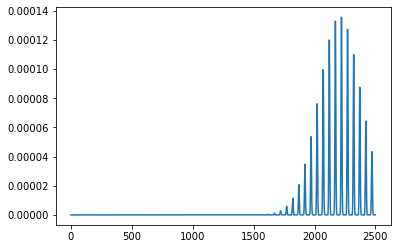

In [42]:
plt.plot(result - out)

In [43]:
%timeit cuda.synchronize(); numba_kde_cuda2c[blocks_per_grid, threads_per_block](eval_points, blob, b, out); cuda.synchronize()

TypeError: Failed in nopython mode pipeline (step: analyzing bytecode)
Signature mismatch: 4 argument types given, but function takes 5 arguments

In [ ]:
np.nonzero(out2.sum(axis=1))[0]

In [ ]:
plt.plot(out2[:128, 0])
plt.plot(out2[:128, 1])

In [ ]:
out2[:128]

In [ ]:
blocks_per_grid